# Project Description

You've received an analytical task from an international online store. Your predecessor failed to complete it: they launched an A/B test and then quit (to start a watermelon farm in Brazil). They left only the technical specifications and the test results.

# Technical description

- Test name: recommender_system_test
- Groups: А (control), B (new payment funnel)
- Launch date: 2020-12-07
- The date when they stopped taking up new users: 2020-12-21
- End date: 2021-01-01
- Audience: 15% of the new users from the EU region
- Purpose of the test: testing changes related to the introduction of an improved recommendation system
- Expected result: within 14 days of signing up, users will show better conversion into product page views (the product_page event), product card views( product_card ) and purchases ( purchase ). At each of the stage of the funnel product_page → product_card → purchase , there will be at least a 10% increase.
- Expected number of test participants: 6000

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
import datetime as dt
from scipy.stats import norm
import scipy.stats as stats

In [2]:
marketing = pd.read_csv('/datasets/ab_project_marketing_events_us.csv',sep=",")
users_event = pd.read_csv('/datasets/final_ab_events_upd_us.csv',sep=",")
users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv',sep=",")
participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv',sep=",")

# Data Preprocessing

## Marketing

In [3]:
marketing

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [4]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [5]:
marketing.isna().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [6]:
marketing.duplicated().sum()

0

In [7]:
marketing['start_dt'] = pd.to_datetime(marketing['start_dt'],format = '%Y-%m-%d')
marketing['finish_dt'] = pd.to_datetime(marketing['finish_dt'],format = '%Y-%m-%d')
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


## Events

In [8]:
users_event

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
423756,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


In [9]:
users_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


In [10]:
users_event.isna().sum()

user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64

In [11]:
users_event.duplicated().sum()

0

In [12]:
users_event['event_dt'] = pd.to_datetime(users_event['event_dt'],format = '%Y-%m-%d %H:%M:%S')
users_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB


In [13]:
users_event['date'] = users_event['event_dt'].dt.date
users_event['date'] = pd.to_datetime(users_event['date'],format = '%Y-%m-%d')
users_event['time'] = users_event['event_dt'].dt.time
users_event.head()

,user_id,event_dt,event_name,details,date,time
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07,20:22:03
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,09:22:53
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07,12:59:29
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,04:02:40
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07,10:15:09


In [14]:
users_event = users_event.fillna(0)
users_event

,user_id,event_dt,event_name,details,date,time
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07,20:22:03
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,09:22:53
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07,12:59:29
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,04:02:40
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07,10:15:09
...,...,...,...,...,...,...
423756,245E85F65C358E08,2020-12-30 19:35:55,login,0.00,2020-12-30,19:35:55
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login,0.00,2020-12-30,10:54:15
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login,0.00,2020-12-30,10:59:09
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,0.00,2020-12-30,09:53:39


## User Data

In [15]:
users

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
58698,1DB53B933257165D,2020-12-20,EU,Android
58699,538643EB4527ED03,2020-12-20,EU,Mac
58700,7ADEE837D5D8CBBD,2020-12-20,EU,PC
58701,1C7D23927835213F,2020-12-20,EU,iPhone


In [16]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [17]:
users.duplicated().sum()

0

In [18]:
users.isna().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [19]:
users['first_date'] = pd.to_datetime(users['first_date'] ,format = '%Y-%m-%d')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB


## A/B participants

In [20]:
participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
...,...,...,...
14520,1D302F8688B91781,B,interface_eu_test
14521,3DE51B726983B657,A,interface_eu_test
14522,F501F79D332BE86C,A,interface_eu_test
14523,63FBE257B05F2245,A,interface_eu_test


In [21]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


In [22]:
participants.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

# Data preparing

In [23]:
events = pd.merge(users_event,participants,how='left')
events.head()

,user_id,event_dt,event_name,details,date,time,group,ab_test
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07,20:22:03,NaN,NaN
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,09:22:53,NaN,NaN
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07,12:59:29,NaN,NaN
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,04:02:40,B,interface_eu_test
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07,10:15:09,NaN,NaN


In [24]:
users = pd.merge(users,participants,how='left')
users.head()

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,F1C668619DFE6E65,2020-12-07,N.America,Android,NaN,NaN
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
3,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone,NaN,NaN


# SDA 

## Check the marketing activities

Lets check the marketing with the test date.

In [25]:
eu_marketing = marketing[marketing['regions'].str.contains('EU')]
start_test = '2020-12-07'
end_test = '2021-01-01'

intersect_marketing = eu_marketing.query('(start_dt >= @start_test and start_dt <= @end_test) or \
                           (finish_dt >= @start_test and finish_dt <= @end_test)')
intersect_marketing

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


**Observation**

Looks like the Christmas&New Year Promo marketing was started during the test. This event might disturb the test later on.

##  Check the test participants

Lets check the test participants test.

In [26]:
participants.groupby(['ab_test','group']).agg({'user_id':'nunique'})

user_id
ab_test                 group         
interface_eu_test       A         5467
                        B         5383
recommender_system_test A         2747
                        B          928

**Observation**

From the 2 test, looks like the participant was overlap with the same eu region. It may distorted our result later. 

Lets check if the participant were overlap with the 2 tests or in 2 group.

In [27]:
recom_test = participants.query('ab_test == "recommender_system_test"')
intersect_participant = (participants[participants['user_id'].isin(recom_test['user_id'].unique())]
                         .groupby(['user_id'])
                         .agg({'ab_test': 'nunique', 'group': 'nunique'})).reset_index()
intersect_participant.head()

,user_id,ab_test,group
0,001064FEAAB631A1,2,1
1,0010A1C096941592,1,1
2,00341D8401F0F665,2,1
3,003DF44D7589BBD4,1,1
4,00505E15A9D81546,1,1


In [28]:
intersect_participant [intersect_participant['group']==2].head()

,user_id,ab_test,group
7,0082295A41A867B5,2,2
10,00E68F103C66C1F7,2,2
32,02313B9E82255F47,2,2
61,04F2CF340B4F3822,2,2
63,051D59BC38C3B3AA,2,2


Looks like the id have 2 test and have 2 groups in it.

Lets find the percentage for the number of id that contain 2 tests or 2 groups

In [29]:
overlap_participants = intersect_participant.query('ab_test > 1 or group > 1').shape[0]
all_participants = len(intersect_participant['user_id'])

print(f'Participants Intersection: {overlap_participants}')
print(f'Percentage Difference: {(overlap_participants / all_participants):.2%}')

Participants Intersection: 887
Percentage Difference: 24.14%


In [30]:
overlap_participants = list(intersect_participant.query('ab_test > 1 or group > 1')['user_id'])
new_participants = participants[(participants['ab_test'] == 'recommender_system_test') & (~participants['user_id'].isin(overlap_participants))]
new_participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
5,7473E0943673C09E,A,recommender_system_test
6,C46FE336D240A054,A,recommender_system_test
...,...,...,...
3670,053FB26D6D49EDDC,A,recommender_system_test
3671,9D263B8EF15CF188,B,recommender_system_test
3672,F2FBBA33F37DEC46,A,recommender_system_test
3673,29C92313A98B1176,B,recommender_system_test


**Observation**

There are 887 participants that intersect between these 2 different test. The percentage difference where 24.14% from all the user ID for both test in total. Because the percentage difference is quite large, therefore computing the tests were obviously will not running correctly.

Therefore, the intersect user ID will be removed 

## Check the participants region

Lets check the participants regions

In [31]:
new_participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
5,7473E0943673C09E,A,recommender_system_test
6,C46FE336D240A054,A,recommender_system_test
...,...,...,...
3670,053FB26D6D49EDDC,A,recommender_system_test
3671,9D263B8EF15CF188,B,recommender_system_test
3672,F2FBBA33F37DEC46,A,recommender_system_test
3673,29C92313A98B1176,B,recommender_system_test


In [32]:
users_test = ((users[users['user_id'].isin(list(new_participants['user_id']))])
              .groupby('region').agg({'user_id':'count'})).sort_values('user_id',ascending=False)
users_test['%'] = (users_test['user_id']/users_test['user_id'].sum()).round(2)
users_test.columns = ['count','%']
users_test

,count,%
region,,
EU,2594,0.93
N.America,119,0.04
APAC,45,0.02
CIS,30,0.01


**Observation**

93% of the users are fom EU region. The 7% differ will be accepted.

Now, lets check if the desired proportion for new users for ab test from the EU region is 15%. 

In [33]:
eu_test_users = users.query('region == "EU" and ab_test == "recommender_system_test" and user_id.isin(@new_participants.user_id)')
eu_users =  users.query('region == "EU" and first_date >= "2020-12-07" and first_date <= " 2020-12-21"')
proportion = (eu_test_users.shape[0])/(eu_users.shape[0])

print (f'Percentage for Desired Proportions : {(proportion):.2%}')

Percentage for Desired Proportions : 6.43%


**Observation**

The proportion is less that what desired proportion required. The different is 8.57 %. This deviation suggests that the test may not have effectively reached the intended number of new users from the EU region.

## Summary

Overall, the data seems to be wrong and not meets the requirement needed. The marketing was intersect with the test would may cause an intervention with the users data. The user ID that intersect with other test also make the test be bias and uncorrectly. The unachieved desired proportion maybe because acquiring new users from EU region can be challenging due to various factors. 

The data still have some general information to see the progress in the test. Yet, lets continued to analyze the to get more understanding and get more information in it without any changing the in the data. The users ID will be used not intersect with other test to prevent any outside influence from it.  

# EDA

Lets filter all the data related

In [34]:
new_events = pd.merge(users[['user_id','first_date']],events, on='user_id',how='outer')
events_test = new_events[(new_events['date'] <= (new_events['first_date'] + pd.DateOffset(days=14))) & (new_events['ab_test'] == 'recommender_system_test')]
events_test = events_test[events_test['user_id'].isin(new_participants['user_id']) ]
events_test

,user_id,first_date,event_dt,event_name,details,date,time,group,ab_test
0,D72A72121175D8BE,2020-12-07,2020-12-07 21:52:10,product_page,0.00,2020-12-07,21:52:10,A,recommender_system_test
1,D72A72121175D8BE,2020-12-07,2020-12-07 21:52:07,login,0.00,2020-12-07,21:52:07,A,recommender_system_test
205,831887FE7F2D6CBA,2020-12-07,2020-12-07 06:50:29,purchase,4.99,2020-12-07,06:50:29,A,recommender_system_test
206,831887FE7F2D6CBA,2020-12-07,2020-12-09 02:19:17,purchase,99.99,2020-12-09,02:19:17,A,recommender_system_test
207,831887FE7F2D6CBA,2020-12-07,2020-12-07 06:50:30,product_cart,0.00,2020-12-07,06:50:30,A,recommender_system_test
...,...,...,...,...,...,...,...,...,...
440771,0416B34D35C8C8B8,2020-12-20,2020-12-21 22:28:29,product_page,0.00,2020-12-21,22:28:29,A,recommender_system_test
440772,0416B34D35C8C8B8,2020-12-20,2020-12-24 09:12:51,product_page,0.00,2020-12-24,09:12:51,A,recommender_system_test
440773,0416B34D35C8C8B8,2020-12-20,2020-12-20 20:58:25,login,0.00,2020-12-20,20:58:25,A,recommender_system_test
440774,0416B34D35C8C8B8,2020-12-20,2020-12-21 22:28:29,login,0.00,2020-12-21,22:28:29,A,recommender_system_test


In [35]:
events_test.isna().sum()

user_id       0
first_date    0
event_dt      0
event_name    0
details       0
date          0
time          0
group         0
ab_test       0
dtype: int64

In [36]:
test_dates = pd.date_range(start = '2020-12-07', periods = 15)

cumulative_test_users = pd.DataFrame(columns = ['A', 'B'])
cumulative_login = pd.DataFrame(columns = ['A', 'B'])
cumulative_product_page = pd.DataFrame(columns = ['A', 'B'])
cumulative_product_cart = pd.DataFrame(columns = ['A', 'B'])
cumulative_purchase = pd.DataFrame(columns = ['A', 'B'])

for i, dt in enumerate(test_dates):

    #Test participants
    current_test_users = events_test.query('first_date <= @dt').groupby('group').agg({'user_id': 'nunique'}).T
    current_test_users['date'] = dt
    current_test_users['test_day'] = i
    cumulative_test_users = cumulative_test_users.append(current_test_users, sort = False)

    # Login
    current_login = events_test.query('event_name == "login" and event_dt <= @dt').groupby('group').agg({'user_id': 'nunique'}).T
    current_login['date'] = dt
    current_login['test_day'] = i
    cumulative_login = cumulative_login.append(current_login, sort=False)
    cumulative_login.reset_index(drop=True, inplace=True)
    
    # Product Page
    current_test_page = events_test.query('event_name == "product_page" and event_dt <= @dt').groupby('group').agg({'user_id': 'nunique'}).T
    current_test_page['date'] = dt
    current_test_page['test_day'] = i
    cumulative_product_page = cumulative_product_page.append(current_test_page, sort=False)
    cumulative_product_page.reset_index(drop=True, inplace=True)
    
    # Product Cart
    current_product_cart = events_test.query('event_name == "product_cart" and event_dt <= @dt').groupby('group').agg({'user_id': 'nunique'}).T
    current_product_cart['date'] = dt
    current_product_cart['test_day'] = i
    cumulative_product_cart = cumulative_product_cart.append(current_product_cart, sort=False)
    cumulative_product_cart.reset_index(drop=True, inplace=True)

    # Purchase
    current_purchase = events_test.query('event_name == "purchase" and event_dt <= @dt').groupby('group').agg({'user_id': 'nunique'}).T
    current_purchase['date'] = dt
    current_purchase['test_day'] = i
    cumulative_purchase = cumulative_purchase.append(current_purchase, sort=False)
    cumulative_purchase.reset_index(drop=True, inplace=True)

## Cumulative New Users 

Cumulative new users by date

In [37]:
cumulative_test_users

,A,B,date,test_day
user_id,118,136,2020-12-07,0.0
user_id,191,169,2020-12-08,1.0
user_id,248,228,2020-12-09,2.0
user_id,299,257,2020-12-10,3.0
user_id,373,272,2020-12-11,4.0
user_id,420,313,2020-12-12,5.0
user_id,464,325,2020-12-13,6.0
user_id,756,384,2020-12-14,7.0
user_id,907,407,2020-12-15,8.0
user_id,1041,482,2020-12-16,9.0


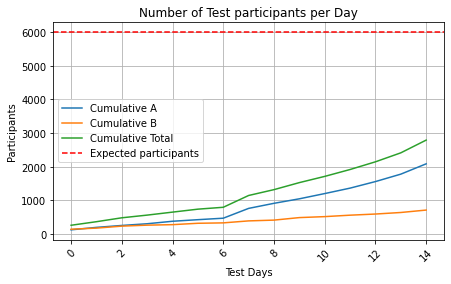

In [38]:
# Create the line plot
plt.figure(figsize=(7, 4))
plt.plot(cumulative_test_users['test_day'], cumulative_test_users['A'], label='Cumulative A')
plt.plot(cumulative_test_users['test_day'], cumulative_test_users['B'], label='Cumulative B')
plt.plot(cumulative_test_users['test_day'], (cumulative_test_users['A'] + cumulative_test_users['B']), label='Cumulative Total')
plt.axhline(y = 6000, label = 'Expected participants', color = 'red', linestyle = '--')

plt.xlabel('Test Days')
plt.xticks(rotation = 45)
plt.ylabel('Participants')
plt.title('Number of Test participants per Day')
plt.grid(True)
plt.legend()
plt.show()

**Observation**

1.  The cumulative number of participants in Group A and Group B increases steadily over time, reaching a total of 2082 and 706 participants. However, Group A are more exponentially increased either than Group B. The cumulative participant count for Group A is much higher than Group B. This suggest that Group A had a larger number of participants overall.

2. We can see the cumulative  number of participants overall reached only 2788, where more less than the expected number of participants which is 6000. This suggest that the test need to give more time to reached the expected number in EU region before doing the test. 

Overall, based on the provided data, Group A had a higher cumulative participant count compared to Group B and the total number of participants falls short of the expected value of 6000. Therefore, the data are not meets the requirement needed.

## Cumulative in Login Events

In [39]:
cumulative_login

,A,B,date,test_day
0,NaN,NaN,2020-12-07,0.0
1,109,124,2020-12-08,1.0
2,186,162,2020-12-09,2.0
3,245,223,2020-12-10,3.0
4,297,253,2020-12-11,4.0
5,372,268,2020-12-12,5.0
6,420,309,2020-12-13,6.0
7,464,323,2020-12-14,7.0
8,756,382,2020-12-15,8.0
9,907,406,2020-12-16,9.0


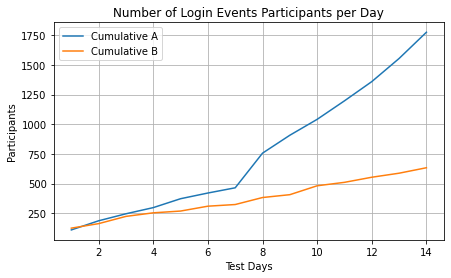

In [40]:
# Create the line plot
plt.figure(figsize=(7, 4))
plt.plot(cumulative_login['test_day'], cumulative_login['A'], label='Cumulative A')
plt.plot(cumulative_login['test_day'], cumulative_login['B'], label='Cumulative B')

plt.xlabel('Test Days')
plt.ylabel('Participants')
plt.title('Number of Login Events Participants per Day')
plt.grid(True)
plt.legend()
plt.show()

**Observation** 

The graph show the number of participant who login for the first time by date. We can see that the exponentially increased in Group A is a prove that it is more effective to get new users to login compared with Group B. Overall, Group A can be expected to get more participants rather than Group B if the test were given more time in future.

## Conversion in Product Page

In [41]:
cumulative_product_page['Conversion_A'] =cumulative_product_page['A']/cumulative_login['A']
cumulative_product_page['Conversion_B'] =cumulative_product_page['B']/cumulative_login['B']
cumulative_product_page

,A,B,date,test_day,Conversion_A,Conversion_B
0,NaN,NaN,2020-12-07,0.0,NaN,NaN
1,70,83,2020-12-08,1.0,0.642202,0.669355
2,124,98,2020-12-09,2.0,0.666667,0.604938
3,158,135,2020-12-10,3.0,0.644898,0.605381
4,186,146,2020-12-11,4.0,0.626263,0.577075
5,227,153,2020-12-12,5.0,0.610215,0.570896
6,256,174,2020-12-13,6.0,0.609524,0.563107
7,282,179,2020-12-14,7.0,0.607759,0.55418
8,485,210,2020-12-15,8.0,0.641534,0.549738
9,587,221,2020-12-16,9.0,0.647189,0.544335


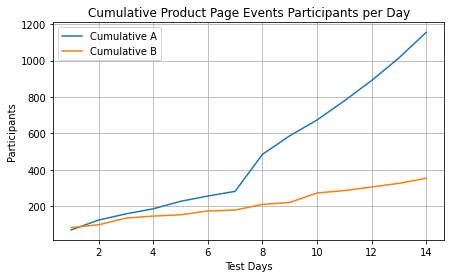

In [42]:
# Create the line plot
plt.figure(figsize=(7, 4))
plt.plot(cumulative_product_page['test_day'], cumulative_product_page['A'], label='Cumulative A')
plt.plot(cumulative_product_page['test_day'], cumulative_product_page['B'], label='Cumulative B')

plt.xlabel('Test Days')
plt.ylabel('Participants')
plt.title('Cumulative Product Page Events Participants per Day')
plt.grid(True)
plt.legend()
plt.show()

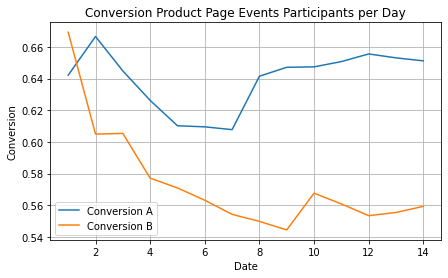

In [43]:
# Create the line plot
plt.figure(figsize=(7, 4))
plt.plot(cumulative_product_page['test_day'], cumulative_product_page['Conversion_A'], label='Conversion A')
plt.plot(cumulative_product_page['test_day'], cumulative_product_page['Conversion_B'], label='Conversion B')

plt.xlabel('Date')
plt.ylabel('Conversion')
plt.title('Conversion Product Page Events Participants per Day')
plt.grid(True)
plt.legend()
plt.show()

**Observation**

The first graph show the number of participant who visits product page for the first time by date. We can see that the exponentially increased in Group A is a prove that it is more effective to attract participant to visit product page compared with Group B. 

The second graph show the conversion of participant who visits the product page from the login events. We can see that conversion for Group A is more stable and much higher than Group B. Conversion for Group B show decreasing and stable on average 0.56 while conversion for Group A are decreasing than start increasing back until the end of the test. On average, conversion for Group A are higher compared to Group B around 10% difference. 

## Conversion in Product Cart

In [44]:
cumulative_product_cart['Conversion_A'] =cumulative_product_cart['A']/cumulative_login['A']
cumulative_product_cart['Conversion_B'] =cumulative_product_cart['B']/cumulative_login['B']
cumulative_product_cart

,A,B,date,test_day,Conversion_A,Conversion_B
0,NaN,NaN,2020-12-07,0.0,NaN,NaN
1,25,36,2020-12-08,1.0,0.229358,0.290323
2,46,47,2020-12-09,2.0,0.247312,0.290123
3,61,64,2020-12-10,3.0,0.24898,0.286996
4,74,69,2020-12-11,4.0,0.249158,0.272727
5,97,72,2020-12-12,5.0,0.260753,0.268657
6,107,77,2020-12-13,6.0,0.254762,0.249191
7,116,80,2020-12-14,7.0,0.25,0.247678
8,211,98,2020-12-15,8.0,0.279101,0.256545
9,273,103,2020-12-16,9.0,0.300992,0.253695


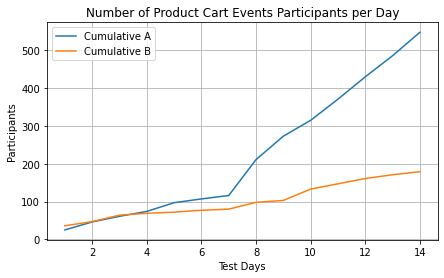

In [45]:
# Create the line plot
plt.figure(figsize=(7, 4))
plt.plot(cumulative_product_cart['test_day'], cumulative_product_cart['A'], label='Cumulative A')
plt.plot(cumulative_product_cart['test_day'], cumulative_product_cart['B'], label='Cumulative B')

plt.xlabel('Test Days')
plt.ylabel('Participants')
plt.title('Number of Product Cart Events Participants per Day')
plt.grid(True)
plt.legend()
plt.show()

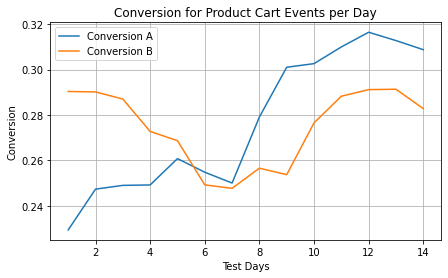

In [46]:
# Create the line plot
plt.figure(figsize=(7, 4))
plt.plot(cumulative_product_cart['test_day'], cumulative_product_cart['Conversion_A'], label='Conversion A')
plt.plot(cumulative_product_cart['test_day'], cumulative_product_cart['Conversion_B'], label='Conversion B')

plt.xlabel('Test Days')
plt.ylabel('Conversion')
plt.title('Conversion for Product Cart Events per Day')
plt.grid(True)
plt.legend()
plt.show()

**Observation**

The first graph show the number of participant who visits product cart for the first time by date. We can see that the exponentially increased in Group A is a prove that it is more effective to attract participant to visit product cart compared with Group B. 

The second graph show the conversion of participant who visits the product cart from the login events. We can see that conversion for Group A is increasing while Group B are go down and up. It suggest that users are very likely to use product cart for the Group A while for the group B a very volatile. It can be assumed, Product Cart for the Group A are more user-friendly compared with group B.

## Conversion in Purchase

In [47]:
cumulative_purchase['Conversion_A'] =cumulative_purchase['A']/cumulative_login['A']
cumulative_purchase['Conversion_B'] =cumulative_purchase['B']/cumulative_login['B']
cumulative_purchase

,A,B,date,test_day,Conversion_A,Conversion_B
0,NaN,NaN,2020-12-07,0.0,NaN,NaN
1,30,47,2020-12-08,1.0,0.275229,0.379032
2,52,54,2020-12-09,2.0,0.27957,0.333333
3,71,65,2020-12-10,3.0,0.289796,0.29148
4,90,72,2020-12-11,4.0,0.30303,0.284585
5,101,74,2020-12-12,5.0,0.271505,0.276119
6,111,84,2020-12-13,6.0,0.264286,0.271845
7,117,87,2020-12-14,7.0,0.252155,0.26935
8,203,102,2020-12-15,8.0,0.268519,0.267016
9,259,108,2020-12-16,9.0,0.285557,0.26601


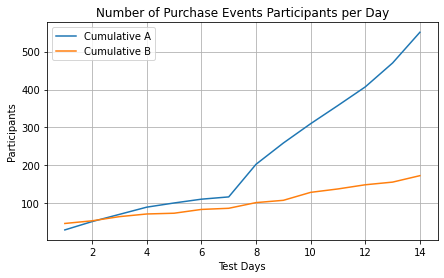

In [48]:
# Create the line plot
plt.figure(figsize=(7, 4))
plt.plot(cumulative_purchase['test_day'], cumulative_purchase['A'], label='Cumulative A')
plt.plot(cumulative_purchase['test_day'], cumulative_purchase['B'], label='Cumulative B')

plt.xlabel('Test Days')
plt.ylabel('Participants')
plt.title('Number of Purchase Events Participants per Day')
plt.grid(True)
plt.legend()
plt.show()

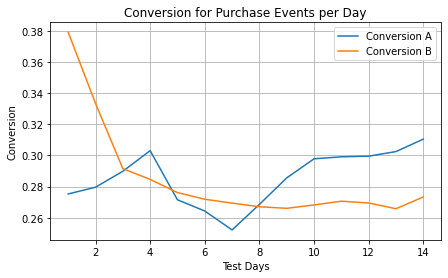

In [49]:
# Create the line plot
plt.figure(figsize=(7, 4))
plt.plot(cumulative_purchase['test_day'], cumulative_purchase['Conversion_A'], label='Conversion A')
plt.plot(cumulative_purchase['test_day'], cumulative_purchase['Conversion_B'], label='Conversion B')

plt.xlabel('Test Days')
plt.ylabel('Conversion')
plt.title('Conversion for Purchase Events per Day')
plt.grid(True)
plt.legend()
plt.show()

**Observation**

The first graph show the number of participant who makes purchases for the first time by date. We can see that the exponentially increased in Group A is a prove that it is more effective to attract participant to make purchases compared with the Group B. 

The second graph show the conversion of participant make purchases from the login events particiants. We can see that conversion for Group A is decreasing and the increasing on halfway test while Group B are decreasing and the stabilize on halfway test. It suggest that users in Group A have a higher potential to make more purchases while users in Group B are more stabilize around 28% from the total number participants to make purchases. Overall, Group A possible to get a higher conversion rate better than group B

## Cumulative Revenue

In [50]:
revenue = events_test.query('details > 0')
revenue = pd.pivot_table(data=revenue, index='date', columns='group', values='details', aggfunc='sum')
revenue = revenue.reset_index().fillna(0)
revenue.columns = ['Date', 'A', 'B']

revenue['Cum_revenueA'] = revenue['A'].cumsum()
revenue['Cum_revenueB'] = revenue['B'].cumsum()
revenue

,Date,A,B,Cum_revenueA,Cum_revenueB
0,2020-12-07,744.70,639.53,744.70,639.53
1,2020-12-08,734.70,344.74,1479.40,984.27
2,2020-12-09,1324.57,354.72,2803.97,1338.99
3,2020-12-10,1189.62,609.80,3993.59,1948.79
4,2020-12-11,959.67,69.89,4953.26,2018.68
5,2020-12-12,729.71,309.78,5682.97,2328.46
6,2020-12-13,254.75,279.83,5937.72,2608.29
7,2020-12-14,2813.96,249.72,8751.68,2858.01
8,2020-12-15,2368.91,1209.80,11120.59,4067.81
9,2020-12-16,2508.87,1364.64,13629.46,5432.45


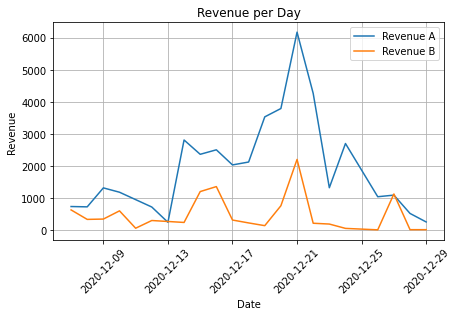

In [51]:
# Create the line plot
plt.figure(figsize=(7, 4))
plt.plot(revenue['Date'], revenue['A'], label='Revenue A')
plt.plot(revenue['Date'], revenue['B'], label='Revenue B')

plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel('Revenue')
plt.title('Revenue per Day')
plt.grid(True)
plt.legend()
plt.show()

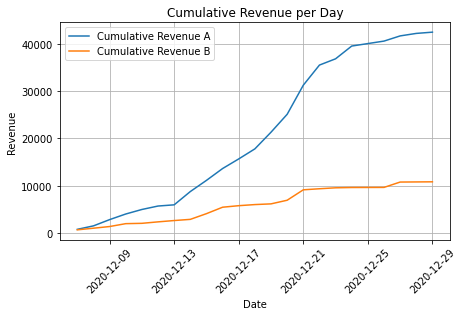

In [52]:
# Create the line plot
plt.figure(figsize=(7, 4))
plt.plot(revenue['Date'], revenue['Cum_revenueA'], label='Cumulative Revenue A')
plt.plot(revenue['Date'], revenue['Cum_revenueB'], label='Cumulative Revenue B')

plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel('Revenue')
plt.title('Cumulative Revenue per Day')
plt.grid(True)
plt.legend()
plt.show()

**Observation**

The first graph show the revenue per day. We can see that Group A more profitable compared with group B with a high margin. 

The second graph show the cumulative revenue per day. We can see that Group A is more exponentially increased while Group B is more linear. It suggest that both gift profit in positive way but Group A can be expected give a higher cumulative revenue in a short time compared with Group B. The reasons maybe due to the higher number of participants. Therefore, we can related that revenue is depends on the number of participants. 

## Summary

Overall, Group A is give a better performance in conversion rate compared with the Group B. Group A have a higher number of participants, give a better conversion rate for every funnel stages and can be expected to give better conversion rate in future.    

# Hypothesis testing

In [53]:
funnel =(events_test.groupby(['event_name','group']).agg({'user_id':'nunique'})).reset_index().sort_values('group',ascending =True)
funnel.columns = ['event_name','group','n_users']

event_sequence = ["login", "product_page", "product_cart", "purchase"]
funnel['event_order'] = pd.Categorical(funnel['event_name'], categories=event_sequence, ordered=True)
funnel = funnel.sort_values('event_order').reset_index()
funnel = funnel.drop('event_order', axis=1).drop('index', axis=1)
funnel

,event_name,group,n_users
0,login,A,2082
1,login,B,705
2,product_page,A,1360
3,product_page,B,397
4,product_cart,A,631
5,product_cart,B,195
6,purchase,A,652
7,purchase,B,198


In [54]:
group_A = funnel.query('group == "A"')
group_B = funnel.query('group == "B"')

group_A['conversion'] = group_A['n_users'] /  group_A['n_users'][:1].tolist()
group_B['conversion'] = group_B['n_users'] /  group_B['n_users'][:1].tolist()

new_funnel = pd.DataFrame(columns=('event_name','A','conversionA','B','conversionB'))

new_funnel['event_name'] = funnel['event_name'].unique()
new_funnel['A'] = group_A['n_users'].values
new_funnel['conversionA'] = group_A['conversion'].values
new_funnel['B'] = group_B['n_users'].values
new_funnel['conversionB'] = group_B['conversion'].values
new_funnel

,event_name,A,conversionA,B,conversionB
0,login,2082,1.000000,705,1.000000
1,product_page,1360,0.653218,397,0.563121
2,product_cart,631,0.303074,195,0.276596
3,purchase,652,0.313160,198,0.280851


Hypothesis test:

Users will show better conversion by 10% into:-

1. product page views
2. product card views
3. purchases

In [55]:
# Define the 10% increase threshold
threshold = 1.1

# Loop through each stage of the funnel
for stage in ['product_page', 'product_cart', 'purchase']:
    # Get the conversion rates for Group A and Group B
    group_a_conversion_rate = new_funnel[new_funnel['event_name'] == stage]['conversionA'].values[0]
    group_b_conversion_rate = new_funnel[new_funnel['event_name'] == stage]['conversionB'].values[0]
    
    # Perform the hypothesis test using the z-criterion
    n_a = new_funnel[new_funnel['event_name'] == stage]['conversionA'].values[0]
    n_b = new_funnel[new_funnel['event_name'] == stage]['conversionB'].values[0]
    p_a = group_a_conversion_rate
    p_b = group_b_conversion_rate
    se_a = ((p_a * (1 - p_a)) / n_a) ** 0.5
    se_b = ((p_b * (1 - p_b)) / n_b) ** 0.5
    z = (p_b - p_a) / ((se_a ** 2) + (se_b ** 2)) ** 0.5
    
    # Calculate the p-value
    p_value = 1 - norm.cdf(abs(z))
    
    # Compare z-score with the critical value at a given significance level (e.g., 0.05)
    significance_level = 0.05
    critical_value = norm.ppf(1 - (significance_level / 2))
    
    # Determine if there is a statistically significant difference between the proportions
    if abs(z) > critical_value:
        if group_b_conversion_rate > threshold * group_a_conversion_rate:
            result = "Statistically significant increase (greater than 10%)"
        else:
            result = "Statistically significant but not greater than 10%"
    else:
        result = "Not statistically significant"
    
    # Print the result for the current stage
    print(f"Stage: {stage}")
    print(f"Z-score: {z}")
    print(f"P-value: {p_value}")
    print(f"Hypothesis test result: {result}")
    print()

Stage: product_page
Z-score: -0.10177672745656156
P-value: 0.45946694925442655
Hypothesis test result: Not statistically significant

Stage: product_cart
Z-score: -0.022217447148205925
P-value: 0.49113725010697984
Hypothesis test result: Not statistically significant

Stage: purchase
Z-score: -0.027248177108979216
P-value: 0.48913089508899055
Hypothesis test result: Not statistically significant



**Observation**

Based on the results of the hypothesis tests, we can observe that for each stage of the funnel (product_page, product_cart, and purchase), the z-scores are negative, indicating that the conversion rates of Group B are lower than those of Group A. However, the z-scores are very close to zero and the corresponding p-values are quite high, indicating that the differences between the groups are not statistically significant.

The p-values in all three stages are approximately 0.48, which is much higher than the commonly used significance level of 0.05. This suggests that the observed differences in conversion rates between Group A and Group B are likely due to chance rather than a true effect. In other words, there is not enough evidence to conclude that there is a significant difference in conversion rates between the two groups.

Therefore, based on these results, we cannot support the hypothesis that there is a 10% or greater increase in conversion rates for Group B compared to Group A at each stage of the funnel.

# Conclusion 

In SDA:

The test was performed incorrectly:

- The test coincided with the other marketing events in the EU region
- Test participants participated in another test which can change or disturb the behavioral participants
- The test where included the other region where the data is not precise
- The test participants were unevenly distributed between the test groups
    
Thus, the test are unvalid and hardly to make any business decision rely to the the test. However, the data still can be used to make overview what happen in the test and we can make general overview by using the data that already being collected. The user ID that intersect with other test will be removed to prevent any outside influence from other test. 

In EDA:

Group A is give a better performance in conversion rate compared with the Group B for every funnel stages. Group A have a higher number of participants, give a better conversion rate for every funnel stages and can be expected to give better conversion rate in future. This result shown that the new recommender system should be viewed with suspicion where the test group were lower than the control group. 

In Hypothesis Test:

Test results show we cannot support the hypothesis that there is a 10% or greater increase in conversion rates for Group B compared to Group A at each stage of the funnel. Therefore, we can prove that the result in EDA is correct and be proven where the control group (Group A) is better than the test group(GroupB).

Therefore, it is recommended to run another test to get a better data and correct results or stop the test and decide where the control group is better than the test group. However, The first opinion is much better decision to be make where we can analyse with the valid test and result to make any business decision.